In [1]:
# import plotly.express as px
# about()
from typing import List
from my_matrix_plot import matrixplot
from sympy.physics.wigner import wigner_3j, wigner_6j
from qutip import *
import scipy.constants as constants
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(rc={
    # "figure.dpi": 100, 
    "figure.figsize": (8, 6)
    })


random.seed(389)
# qutip.settings.auto_tidyup = True
# from sympy.physics.wigner import clebsch_gordan

PROBE_BEAM_WAIST = (
    ((1.552 + 1.613 + 1.593 + 1.606) / 4) / 2 * 1e-3
)  # in m, waist radius
PUMP_BEAM_WAIST = ((2.476 + 2.644 + 2.426 + 2.611) / 4) / \
    2 * 1e-3  # in m, waist radius
# We set hbar = 1
pi = np.pi
A_S = 3.417341305452145e09 * 2 * pi  # Hz
A_P12 = 407.25e6 * 2 * pi
A_P32 = 84.7185e6 * 2 * pi
B_P32 = 12.4965e6 * 2 * pi
I = 3 / 2
MU_BOHR = 2 * pi * 1.399624604e6  # Hz / G


def K_factor(F, J):
    return F * (F + 1) - I * (I + 1) - J * (J + 1)


def Eg(F):
    Jg = 1 / 2
    return 1 / 2 * A_S * K_factor(F, Jg)


def Delta_E_P12(F):
    Je = 1 / 2
    return 1 / 2 * A_P12 * K_factor(F, Je)


def Delta_E_P32(F):
    Je = 3 / 2
    K = K_factor(F, Je)
    return (1 / 2 * A_P32 * K + B_P32
            * (3 / 2 * K * (K + 1) - 2 * I * (I + 1) * Je * (Je + 1))
            / (4 * I * (2 * I - 1) * Je * (2 * Je - 1)))


def ket_Fg(F, mF):
    assert F in (1, 2)
    assert abs(mF) <= F
    if F == 1:
        return basis(8, mF + F)
    elif F == 2:
        return basis(8, mF + F + 3)
    else:
        raise ValueError


def get_ket_Fg_D1(F, mF):
    return Qobj(
        np.concatenate((ket_Fg(F, mF).full().flatten(),
                       np.zeros(8, dtype=np.cdouble)))
    )


def get_ket_Fg_D2(F, mF):
    return Qobj(
        np.concatenate((ket_Fg(F, mF).full().flatten(),
                       np.zeros(16, dtype=np.cdouble)))
    )


def ket_Fe_D1(F, mF):
    assert F in (1, 2)
    assert abs(mF) <= F
    if F == 1:
        return basis(8, mF + F)
    elif F == 2:
        return basis(8, mF + F + 3)
    else:
        raise ValueError


def ket_Fe_D2(F, mF):
    assert F in (0, 1, 2, 3)
    assert abs(mF) <= F
    if F == 0:
        return basis(16, 0)
    elif F == 1:
        return basis(16, mF + F + 1)
    elif F == 2:
        return basis(16, mF + F + 4)
    elif F == 3:
        return basis(16, mF + F + 9)
    else:
        raise ValueError


def get_ket_Fe_D2(F, mF):
    return Qobj(
        np.concatenate(
            (np.zeros(8, dtype=np.cdouble), ket_Fe_D2(F, mF).full().flatten())
        )
    )


def get_ket_Fe_D1(F, mF):
    return Qobj(
        np.concatenate(
            (np.zeros(8, dtype=np.cdouble), ket_Fe_D1(F, mF).full().flatten())
        )
    )


def H_atom(det_Light, line: str):
    sum_Fg = sum(
        [Eg(f) * ket_Fg(f, m).proj() for f in (1, 2) for m in range(-f, f + 1)]
    )
    if line == "D1":
        h = np.zeros(shape=(16, 16), dtype=np.cdouble)
        sum_Fe_D1 = sum(
            [
                (Delta_E_P12(f) - det_Light) * ket_Fe_D1(f, m).proj()
                for f in (1, 2)
                for m in range(-f, f + 1)
            ]
        )
        h[:8, :8] = sum_Fg
        h[8:, 8:] = sum_Fe_D1
        return Qobj(h)
    elif line == "D2":
        h = np.zeros(shape=(24, 24), dtype=np.cdouble)
        sum_Fe_D2 = sum(
            [
                (Delta_E_P32(f) - det_Light) * ket_Fe_D2(f, m).proj()
                for f in (0, 1, 2, 3)
                for m in range(-f, f + 1)
            ]
        )
        h[:8, :8] = sum_Fg
        h[8:, 8:] = sum_Fe_D2
        return Qobj(h)
    else:
        raise ValueError


def sigma_q(q, line: str) -> Qobj:      # "weighted lowering operator", m_F = m'_F + q
    assert q in (-1, 0, 1)
    assert line in ("D1", "D2")
    Jg = 1 / 2
    if line == "D1":
        Je = 1 / 2
        opers = []
        op = np.zeros(shape=(16, 16), dtype=np.cdouble)
        for Fg in (1, 2):
            for mg in range(-Fg, Fg + 1):
                for Fe in (1, 2):
                    for me in range(-Fe, Fe + 1):
                        weight = (
                            (-1) ** (Fe + Jg + 1 + I)
                            * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                            * (-1) ** (-Fe + 1 - mg)
                            * (2 * Fg + 1) ** (1 / 2)
                            * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                        )
                        lowering_operator = ket_Fg(
                            Fg, mg) * ket_Fe_D1(Fe, me).dag()
                        op[:8, 8:] = weight * lowering_operator
                        opers.append(Qobj(op))
        return sum(opers)
    elif line == "D2":
        Je = 3 / 2
        opers = []
        op = np.zeros(shape=(24, 24), dtype=np.cdouble)
        for Fg in (1, 2):
            for mg in range(-Fg, Fg + 1):
                for Fe in (0, 1, 2, 3):
                    for me in range(-Fe, Fe + 1):
                        weight = (
                            (-1) ** (Fe + Jg + 1 + I)
                            * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                            * (-1) ** (Fe - 1 + mg)
                            * (2 * Fg + 1) ** (1 / 2)
                            * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                        )
                        lowering_operator = ket_Fg(
                            Fg, mg) * ket_Fe_D2(Fe, me).dag()
                        op[:8, 8:] = weight * lowering_operator
                        opers.append(Qobj(op))
        return sum(opers)
    else:
        raise ValueError


def E_0_plus(
    intensity,
):  # we assume pure polarization and either sigma plus or minus or linearly pol
    return (2 * intensity / (constants.c * constants.epsilon_0)) ** (1 / 2) / 2


def get_probe_intensity(power):
    """power in W, returns intensity in W/m**2"""
    return power / ((PROBE_BEAM_WAIST) ** 2 * pi)


def get_pump_intensity(power):
    """power in W, returns intensity in W/m**2"""
    return power / ((PUMP_BEAM_WAIST) ** 2 * pi)


def rabi_D1_vector_component(E_field_component):
    dipole = 2.5377e-29  # dipole transition matrix element
    return 2 * dipole * E_field_component / constants.hbar


def rabi_D2_vector_component(E_field_component):
    dipole = 3.58424e-29  # dipole transition matrix element
    return 2 * dipole * E_field_component / constants.hbar


def H_atom_field_D1(q, E_field_component):
    tmp = (
        1 / 2
        * np.conjugate(rabi_D1_vector_component(E_field_component))
        * sigma_q(q, "D1")
    )
    return tmp + tmp.dag()


def H_atom_field_D2(q, E_field_component):
    tmp = (
        1 / 2
        * np.conjugate(rabi_D2_vector_component(E_field_component))
        * sigma_q(q, "D2")
    )
    return tmp + tmp.dag()


#   Use these functions to setup laser:
F2_FP1_FREQUENCY_D1 = (-509.06e6 - 2.563005979089109e9) * 2 * pi


def laser_sigma_plus_F2_FP1_D1(intensity, det=0.0):
    h = H_atom_field_D1(-1, E_0_plus(intensity)) + H_atom(
        F2_FP1_FREQUENCY_D1 + det, "D1"
    )
    # h[:3, :] = 0.0
    # h[:, :3] = 0.0
    return h


def laser_sigma_minus_F2_FP1_D1(intensity, det=0.0):
    h = H_atom_field_D1(1, E_0_plus(intensity)) + H_atom(
        F2_FP1_FREQUENCY_D1 + det, "D1"
    )
    # h[:3, :] = 0.0
    # h[:, :3] = 0.0
    return h


F2_FP2_FREQUENCY_D1 = -1.61038415e10 + 1.91912041e09


def laser_sigma_plus_F2_FP2_D1(intensity, det=0.0):
    h = H_atom_field_D1(-1, E_0_plus(intensity)) + H_atom(
        F2_FP2_FREQUENCY_D1 + det, "D1"
    )
    # h[:3, :] = 0.0
    # h[:, :3] = 0.0
    return h


def laser_pi_F2_FP2_D1(intensity, det=0.0):
    h = H_atom_field_D1(0, E_0_plus(intensity)) + H_atom(
        F2_FP2_FREQUENCY_D1 + det, "D1"
    )

    return h


def laser_sigma_minus_F2_FP2_D1(intensity, det=0.0):
    h = H_atom_field_D1(1, E_0_plus(intensity)) + H_atom(
        F2_FP2_FREQUENCY_D1 + det, "D1"
    )
    # h[:3, :] = 0.0
    # h[:, :3] = 0.0
    return h


F1_FP_FREQUENCY_D1 = 2.68397359e10


def laser_sigma_plus_F1_FP_D1(intensity, det=0.0):
    h = H_atom_field_D1(-1, E_0_plus(intensity)) + H_atom(
        F1_FP_FREQUENCY_D1 + det, "D1"
    )
    # h[3:8, :] = 0.0
    # h[:, 3:8] = 0.0
    return h


# def laser_sigma_minus_D1(intensity, detuning=0.0):
#     return H_atom_field_D1(1, E_0_plus(intensity)) + H_atom(detuning, "D1")

# def laser_linear_D1(intensity, detuning=0.0):
#     return H_atom_field_D1(-1, E_0_plus(intensity/2)) + H_atom_field_D1(1, E_0_plus(intensity/2)) + H_atom(detuning, "D1")

CYCLING_TRANSITION_D2 = (193.7407e6 - 2.563005979089109e9) * 2 * pi


def laser_sigma_plus_cycling_D2(intensity, detuning=0.0):
    return H_atom_field_D2(-1, E_0_plus(intensity)) + H_atom(
        CYCLING_TRANSITION_D2 + detuning, "D2"
    )


# def laser_sigma_minus_D2(intensity, detuning=0.0):
#     return H_atom_field_D2(1, E_0_plus(intensity)) + H_atom(detuning, "D2")

# def laser_linear_D2(intensity, detuning=0.0):
#     return H_atom_field_D2(-1, E_0_plus(intensity) / 2) + H_atom_field_D2(1, E_0_plus(intensity) / 2) + H_atom(detuning, "D2")

# far detuned saturation intensity for D1, pi pol. Is this value even relevant for pumping ?
OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL = 4.4876 * 1e-3 / (1e-2) ** 2
SATURATION_INTENSITY_D2_SIGMA_PM_CYCLING = 1.66933 * (1e-3) / (1e-2) ** 2
GAMMA_RAD_D1 = 5.7500e6 * 2 * pi
GAMMA_RAD_D2 = 6.0666e6 * 2 * pi
QUENCHING_RATE = 8.4e7


def natural_decay_ops_D2():
    return [(2 * GAMMA_RAD_D2) ** (1 / 2) * sigma_q(q, "D2") for q in (-1, 0, 1)]


def natural_decay_ops_D1():
    return [GAMMA_RAD_D1 ** (1 / 2) * sigma_q(q, "D1") for q in [-1, 0, 1]]


def quenching_ops(line: str, gamma=QUENCHING_RATE):
    if line == "D1":
        return [
            # sum(
            # [
            # sum(
            # [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D1(fg, mg)
            * get_ket_Fe_D1(fe, me).dag()
            for fg in (1, 2)
            for mg in range(-fg, fg + 1)
            # ]
            # )
            for fe in (1, 2)
            for me in range(-fe, fe + 1)
            # ]
            # )
        ]
    elif line == "D2":
        return [
            # sum(
            # [
            # sum(
            # [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D2(fg, mg)
            * get_ket_Fe_D2(fe, me).dag()
            for fg in (1, 2)
            for mg in range(-fg, fg + 1)
            # ]
            # )
            for fe in (0, 1, 2, 3)
            for me in range(-fe, fe + 1)
            # ]
            # )
        ]
    else:
        raise ValueError


def intra_F_ground_decay(line: str, gamma=5e3):
    if line == "D1":
        return [
            # sum(
            #     [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D1(f, mb)
            * get_ket_Fg_D1(f, ma).dag()
            for f in (1, 2)
            for mb in range(-f, f + 1)
            #     ]
            # )
            for ma in range(-f, f + 1)
        ]
    elif line == "D2":
        return [
            # sum(
            #     [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D2(f, mb)
            * get_ket_Fg_D2(f, ma).dag()
            for f in (1, 2)
            for mb in range(-f, f + 1)
            #     ]
            # )
            for ma in range(-f, f + 1)
        ]
    else:
        raise ValueError


# def intra_F_excited_decay(line: str, gamma=1e4):


def F2_to_F1_ground_state_decay(line: str, gamma=3e3) -> List:
    if line == "D1":
        return [
            # sum(
            #     [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D1(1, mf)
            * get_ket_Fg_D1(2, ms).dag()
            for mf in (-1, 0, 1)
            #     ]
            # )
            for ms in range(-2, 3)
        ]
    elif line == "D2":
        return [
            # sum(
            #     [
            (gamma) ** (1 / 2)
            * get_ket_Fg_D2(1, mf)
            * get_ket_Fg_D2(2, ms).dag()
            for mf in (-1, 0, 1)
            #     ]
            # )
            for ms in range(-2, 3)
        ]
    else:
        raise ValueError


def F1_to_F2_ground_state_decay(line: str, gamma=3e3) -> List:
    tmp = [
        # sum(
        #     [
        (gamma) ** (1 / 2) * ket_Fg(2, ms) * ket_Fg(1, mf).dag()
        for ms in range(-2, 3)
        #     ]
        # )
        for mf in (-1, 0, 1)
    ]
    dims_op = 16 if line == "D1" else 24
    ops = []
    for op in tmp:
        c = np.zeros(shape=(dims_op, dims_op), dtype=np.cdouble)
        c[:8, :8] = op.full()
        ops.append(Qobj(c))
    return ops


def wall_coll(line, gamma=1e3):
    dims_op = 16 if line == "D1" else 24
    return [
        (gamma) ** (1 / 2)
        * basis(dims_op, end)
        * basis(dims_op, begin).dag()
        for end in range(8)
        for begin in range(8)
        # if begin != end
    ]


def dephasing_excited_states(line: str, gamma=1e7):  # value for rate???
    if line == "D1":
        return [
            (gamma) ** (1 / 2) * get_ket_Fe_D1(f, mf).proj()
            for f in (1, 2)
            for mf in range(-f, f + 1)
        ]
    elif line == "D2":
        return [
            (gamma) ** (1 / 2) * get_ket_Fe_D2(f, mf).proj()
            for f in range(4)
            for mf in range(-f, f + 1)
        ]


def dephasing_ground_states(line: str, gamma=1e3):
    if line == "D1":
        return [
            (gamma) ** (1 / 2) * get_ket_Fg_D1(f, mf).proj()
            for f in (1, 2)
            for mf in range(-f, f + 1)
        ]
    elif line == "D2":
        return [
            (gamma) ** (1 / 2) * get_ket_Fg_D2(f, mf).proj()
            for f in (1, 2)
            for mf in range(-f, f + 1)
        ]


def index_to_F_mF_string_D1(ind):
    if ind < 3:
        return rf"""$F=1, m={ind - 1}$"""
    elif ind < 8:
        return rf"""$F=2, m={ind - 2 - 3}$"""
    elif ind < 8 + 3:
        return rf"""$F'=1, m={ind - 1 - 8}$"""
    else:
        return rf"""$F'=2, m={ind - 2 - 8 - 3}$"""


def index_to_F_mF_string_D2(ind):
    if ind < 3:
        return rf"""$F=1, m={ind - 1}$"""
    elif ind < 8:
        return rf"""$F=2, m={ind - 2 - 3}$"""
    elif ind == 8:
        return rf"""$F'=0, m={ind - 8}$"""
    elif ind in (9, 10, 11):
        return rf"""$F'=1, m={ind - 10}$"""
    elif ind in (12, 13, 14, 15, 16):
        return f"""$F'=2, m={ind - 14}$"""
    else:
        return f"""$F'=3, m={ind - 20}$"""


def maplot(
    op: Qobj, std_xlabels=True, std_ylabels=True, annot=False, figsize=(2 * 8.4, 6.72)
):
    if op.shape[0] == 16:
        fig, axs = matrixplot(
            op,
            xlabels=[index_to_F_mF_string_D1(ind)
                     for ind in range(op.shape[0])]
            if std_xlabels
            else "auto",
            ylabels=[index_to_F_mF_string_D1(ind)
                     for ind in range(op.shape[0])]
            if std_ylabels
            else "auto",
            annot=annot,
            figsize=figsize,
        )
        return fig, axs
    else:
        fig, axs = matrixplot(
            op,
            xlabels=[index_to_F_mF_string_D2(ind)
                     for ind in range(op.shape[0])]
            if std_xlabels
            else "auto",
            ylabels=[index_to_F_mF_string_D2(ind)
                     for ind in range(op.shape[0])]
            if std_ylabels
            else "auto",
            annot=annot,
            figsize=figsize,
        )
        return fig, axs


def plot_ground_states_time(res_, axs=None):
    dimension = res_.states[0].shape[0]
    ground_exp_val_ = [[res_.states[t].diag()[k]
                        for t in range(len(res_.times))] for k in range(8)]
    if axs is not None:
        fig = axs[0, 0].get_figure()
    else:
        fig, axs = plt.subplots(
            ncols=5, nrows=2, figsize=(12, 6), sharex="all", sharey="all"
        )
        # axs[1,0].remove()
        # axs[1,4].remove()
    for i, e in enumerate(ground_exp_val_[:3]):
        axs[1, 1 + i].plot(res_.times, np.real(e))
    for i, e in enumerate(ground_exp_val_[3:8]):
        axs[0, i].plot(res_.times, np.real(e))
    fig.suptitle("Ground States")
    axs[1, 2].set_xlabel("Time (s)")
    plt.tight_layout()
    return fig, axs


def plot_excited_states_time(res_, axs=None):
    dimension = res_.states[0].shape[0]
    excited_exp_val_ = [[res_.states[t].diag()[k] for t in range(
        len(res_.times))] for k in range(8, dimension)]

    if dimension == 16:
        if axs is not None:
            fig = axs[0, 0].get_figure()
        else:
            fig, axs = plt.subplots(
                ncols=5, nrows=2, figsize=(12, 6), sharex="all", sharey="all"
            )
        for i, e in enumerate(excited_exp_val_[:3]):
            axs[1, 1 + i].plot(res_.times, np.real(e))
        for i, e in enumerate(excited_exp_val_[3:8]):
            axs[0, i].plot(res_.times, np.real(e))
        fig.suptitle("Excited States")
        axs[1, 2].set_xlabel("Time (s)")
        plt.tight_layout()
        return fig, axs
    elif dimension == 24:
        if axs is not None:
            fig = axs[0, 0].get_figure()
        else:
            fig, axs = plt.subplots(
                ncols=7, nrows=4, figsize=(12, 12), sharex="all", sharey="all"
            )
        for i, e in enumerate(excited_exp_val_[-7:]):
            axs[0, i].plot(res_.times, np.real(e))
        for i, e in enumerate(excited_exp_val_[-12:-7]):
            axs[1, 1 + i].plot(res_.times, np.real(e))
        for i, e in enumerate(excited_exp_val_[1:4]):
            axs[2, 2 + i].plot(res_.times, np.real(e))
        axs[3, 3].plot(res_.times, np.real(excited_exp_val_[0]))
        fig.suptitle("Excited States")
        axs[3, 3].set_xlabel("Time (s)")
        plt.tight_layout()
        return fig, axs
    else:
        raise ValueError


def plot_total_ground_pop(resa):
    fig, ax = plt.subplots()
    ax.plot(resa.times, [sum(elem.diag()[:8])
            for elem in resa.states], label="Ground")
    ax.set_ylabel("Total Ground state population")
    ax.set_xlabel("time (s)")
    # ax.legend()
    plt.tight_layout()
    return fig, ax


def plot_bar_ground_pop(rho):
    # populations plot
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharey="all", sharex="all")
    ax2.bar(list(range(-1, 2)), rho.diag().real[:3], color="tab:blue")
    ax1.set_title("F=2")
    ax1.bar(list(range(-2, 3)), rho.diag().real[3:8], color="tab:blue")
    ax2.set_title("F=1")
    fig.suptitle("Ground States")
    plt.tight_layout()
    return fig, [ax1, ax2]


def plot_bar_excited_pop_D1(rho):
    # populations plot
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharey="all", sharex="all")
    ax2.bar(list(range(-1, 2)), rho.diag().real[8:3+8], color="tab:blue")
    ax1.set_title("F=2")
    ax1.bar(list(range(-2, 3)), rho.diag().real[3+8:8+8], color="tab:blue")
    ax2.set_title("F=1")
    fig.suptitle("Excited States")
    plt.tight_layout()
    return fig, [ax1, ax2]


def f_ground_states_uncoupled():
    hb0 = H_hfs_ground() + H_B(bz=1e-6)
    eigvals, eigstates = hb0.eigenstates()
    F_states_reordered = [
        eigstates[2],
        eigstates[1],
        eigstates[0],
    ]  # to have same basis in the same order: |F=1, m=-1>, |F=1, m=0>, ...
    for k in range(3, 3 + 5):
        F_states_reordered.append(eigstates[k])
    eigvals_reordered = [eigvals[2], eigvals[1], eigvals[0]]
    for k in range(3, 3 + 5):
        eigvals_reordered.append(eigvals[k])
    return eigvals_reordered, F_states_reordered


def H_hfs_ground():
    """in uncoupled basis !"""
    return A_S * (
        tensor(spin_Jz(3 / 2), spin_Jz(1 / 2))  # I * J (S_1/2, where L=0)
        + tensor(spin_Jy(3 / 2), spin_Jy(1 / 2))
        + tensor(spin_Jx(3 / 2), spin_Jx(1 / 2))
    )


def H_B(bx=0, by=0, bz=0):  # in G
    """in uncoupled basis !"""
    return (
        2.0023193043622
        * (
            tensor(qeye(4), spin_Jx(1 / 2)) * bx
            + tensor(qeye(4), spin_Jy(1 / 2)) * by
            + tensor(qeye(4), spin_Jz(1 / 2)) * bz
        )
        - 0.000995
        * (
            tensor(spin_Jx(3 / 2), qeye(2)) * bx
            + tensor(spin_Jy(3 / 2), qeye(2)) * by
            + tensor(spin_Jz(3 / 2), qeye(2)) * bz
        )
    ) * MU_BOHR


def B_loop(
    power_mw, power_ratio_reflected=10 ** (-13.5 / 10), radius=0.7e-2, distance=0.03
):
    """in Gauss"""
    power = power_mw * (1 - power_ratio_reflected)
    return (
        constants.mu_0
        * radius**2
        * (power / 50) ** (1 / 2)
        / (2 * (distance**2 + radius**2) ** (3 / 2))
        * 1e4
    )


def H_mw(Bmw_x, Bmw_y, Bmw_z, line="D1", det_mw=0.0, b_static_z=0.08):
    """Total Hamiltonian for atom-MW interaction (no laser).
    Detuning from clock transition"""
    hb0 = H_hfs_ground() + H_B(bz=b_static_z)  # atom in static magnetic, longitudinal field
    eigvals, eigstates = hb0.eigenstates()
    F_states_reordered = [
        eigstates[2],
        eigstates[1],
        eigstates[0],
    ]  # reorder the eigenstates to have same basis in the same order: |F=1, m=-1>, |F=1, m=0>, ...
    for k in range(3, 3 + 5):
        F_states_reordered.append(eigstates[k])
    eigvals_reordered = [eigvals[2], eigvals[1], eigvals[0]]
    for k in range(3, 3 + 5):
        eigvals_reordered.append(eigvals[k])

    energ_shifted = [
        en - eigvals_reordered[1] for en in eigvals_reordered
    ]  # shift energies so that |F=1, mF=0> corresponds to 0 energy
    ens = [
        en if k < 3 else en - energ_shifted[5]  # rotating frame
        for k, en in enumerate(energ_shifted)
    ]
    # ens = eigvals_reordered
    # det_mw -=
    h_a = sum(
        [(ens[m + 2 + 3] - det_mw) * ket_Fg(2, m).proj()
         for m in range(-2, 2 + 1)]
    ) + sum([ens[m + 1] * ket_Fg(1, m).proj() for m in range(-1, 2)])
    dims = 16 if line == "D1" else 24
    hb_ac = H_B(bx=Bmw_x, by=Bmw_y, bz=Bmw_z).transform(F_states_reordered)
    hb_ac = hb_ac.full()
    for i in range(7):  # RWA
        hb_ac[i, i + 1] = 0.0
        hb_ac[i + 1, i] = 0.0
    h_a_mw = np.zeros(shape=(dims, dims), dtype=np.cdouble)
    h_a_mw[:8, :8] = h_a
    h_a_mw[:8, :8] = hb_ac + h_a_mw[:8, :8]
    return Qobj(h_a_mw)


def get_equally_ground_state_D1():
    return sum([basis(16, i).proj() for i in range(8)]).unit()


def get_equally_ground_state_D2():
    return sum([basis(24, i).proj() for i in range(8)]).unit()


def projector_excited_D1():
    return sum([basis(16, k).proj() for k in range(8, 16)])


def projector_excited_D2():
    return sum([basis(24, k).proj() for k in range(8, 24)])


def spec_solve(freq):
    steps = 5000
    res_spec = mesolve(
        laser_sigma_plus_F2_FP1_D1(1e-3, det=freq),
        rho0=get_equally_ground_state_D1(),
        tlist=np.linspace(0, 1e-6, 100),
        c_ops=natural_decay_ops_D1() + quenching_ops(line="D1"),
        e_ops=[projector_excited_D1()],
        options=Options(nsteps=steps),
    )
    return res_spec.expect[0][-1]


def test_D2_saturation():
    """Test if we get a quarter of the population in the excited state for the saturation intensity."""
    hamil = laser_sigma_plus_cycling_D2(
        SATURATION_INTENSITY_D2_SIGMA_PM_CYCLING)
    liou = liouvillian(hamil, c_ops=natural_decay_ops_D2())
    rho_ss = steadystate(liou)
    print(
        f"Excited states populations D2 at saturation intensity: {rho_ss.matrix_element(get_ket_Fe_D2(3, 3).dag(), get_ket_Fe_D2(3, 3)):.3f}"
    )

In [2]:
h = H_atom_field_D1(-1, E_0_plus(10)) + H_atom(0, "D1")

In [3]:
h

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[-2.68397359e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.01490604e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.01490604e+06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.68397359e+10  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.01490604e+06  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.22197044e+06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.68397359e+10  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.38498141e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.61038415e+10
   0.00000000e+00  0.00000000e+00  0.00000000

In [4]:
freqs = np.linspace(-10*2*pi, 10*2*pi, 51)

In [5]:
decays = natural_decay_ops_D1()

In [6]:
decays = natural_decay_ops_D1() + wall_coll(line="D1")

In [7]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(10)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

In [8]:
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]

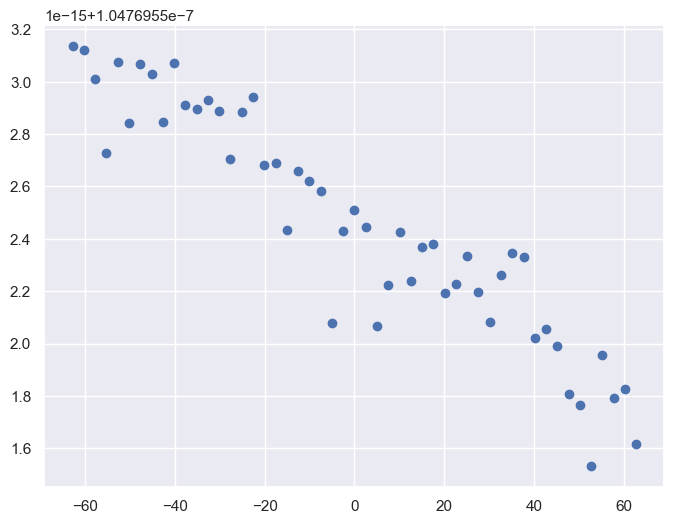

In [9]:
plt.plot(freqs, excited_pops, "o")

In [10]:
freqs = np.linspace(-10e9*2*pi, 10e9*2*pi, 51)

In [11]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(10)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

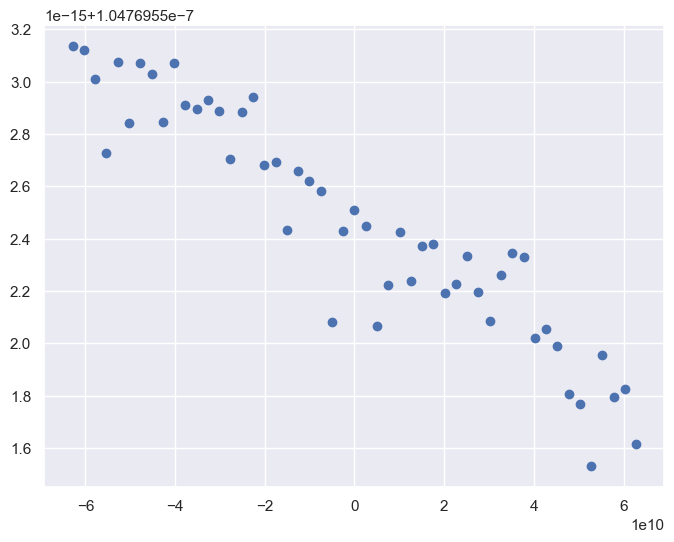

In [12]:
plt.plot(freqs, excited_pops, "o")

In [13]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(100)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

In [14]:
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]

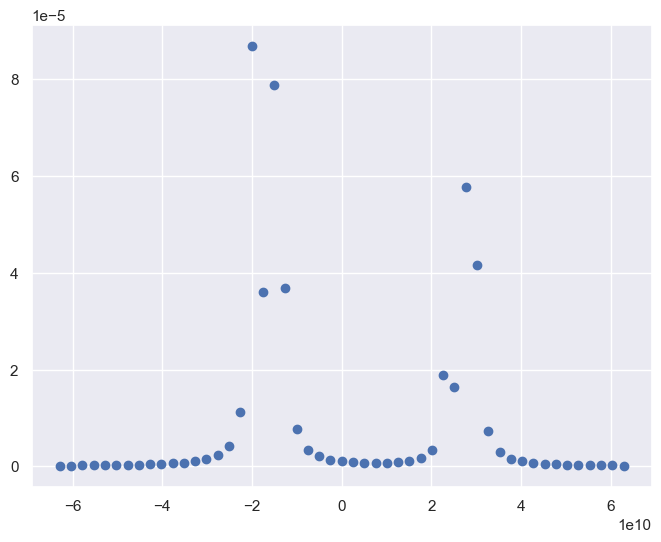

In [15]:
plt.plot(freqs, excited_pops, "o")

In [16]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.1)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

In [17]:
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]

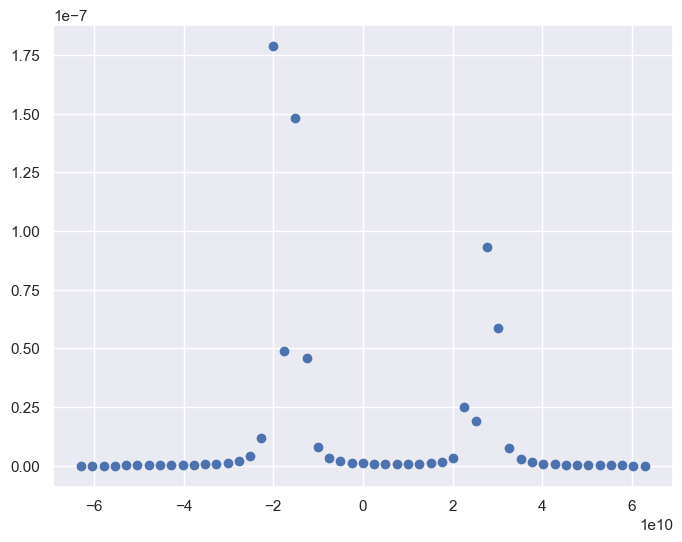

In [18]:
plt.plot(freqs, excited_pops, "o")

In [19]:
freqs = np.linspace(-5e9*2*pi, 5e9*2*pi, 501)

In [20]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.1)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

In [21]:
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]

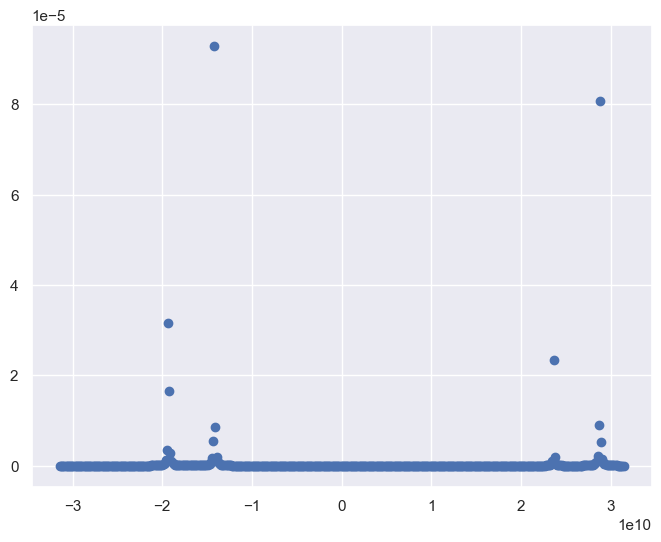

In [22]:
plt.plot(freqs, excited_pops, "o")

In [23]:
freqs = np.linspace(-2e9*2*pi, -1.8e9*2*pi, 501)

In [24]:
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.1)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]

In [25]:
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]

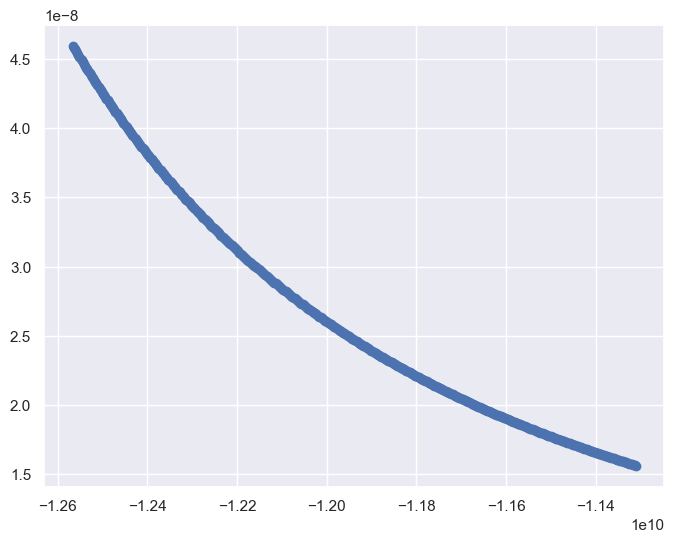

In [26]:
plt.plot(freqs, excited_pops, "o")

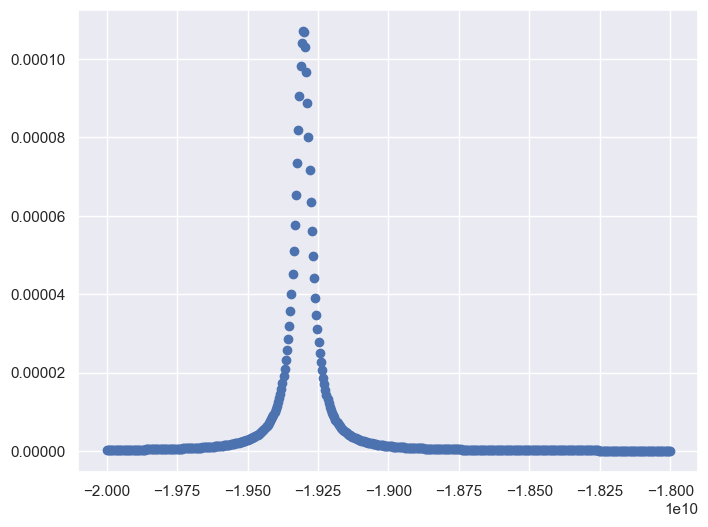

In [27]:
freqs = np.linspace(-2e10, -1.8e10, 501)
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.1)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.plot(freqs, excited_pops, "o")

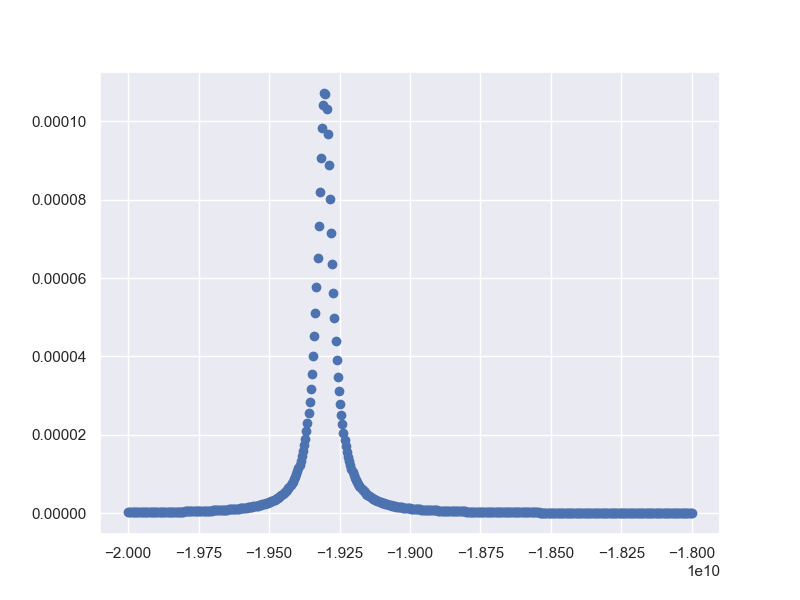

In [28]:
%matplotlib widget
plt.plot(freqs, excited_pops, "o")

In [29]:
6e7/(2*pi)

9549296.58551372

In [30]:
freqs = np.linspace(-2e10, -1.8e10, 501)
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(10)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.plot(freqs, excited_pops, "o")

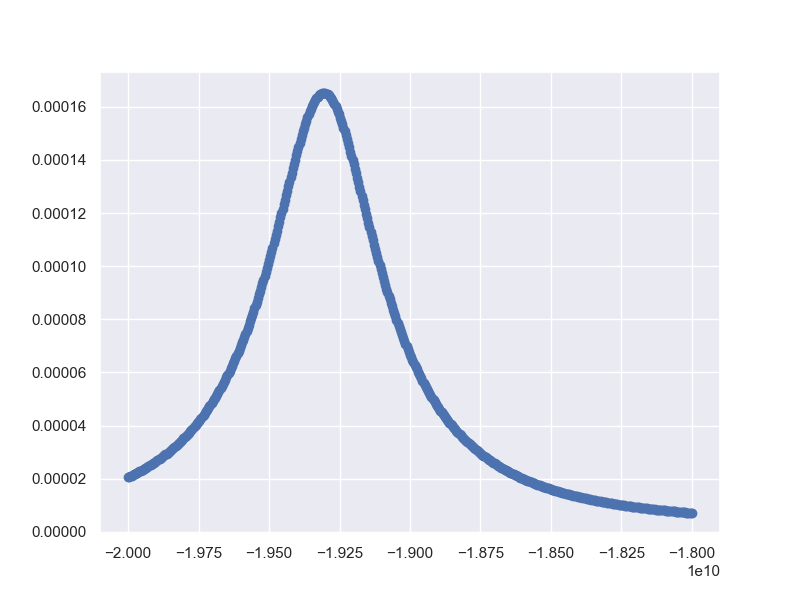

In [31]:
plt.figure()
plt.plot(freqs, excited_pops, "o")

In [32]:
460/(2*pi)

73.21127382227186

In [33]:
decays = natural_decay_ops_D1() + wall_coll(line="D1") + quenching_ops("D1")

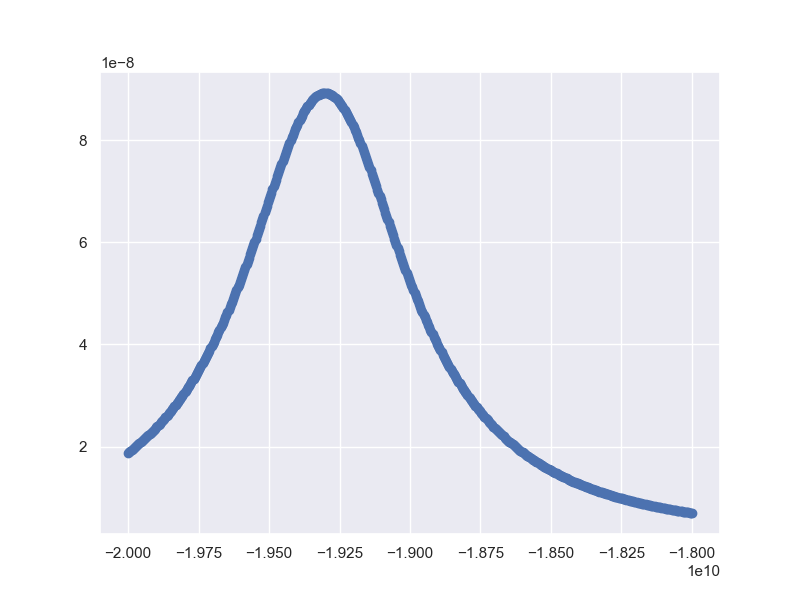

In [34]:
freqs = np.linspace(-2e10, -1.8e10, 501)
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.figure()
plt.plot(freqs, excited_pops, "o")

In [35]:
84/(2*pi)

13.36901521971921

In [36]:
GAMMA_RAD_D1

36128315.51628262

In [37]:
QUENCHING_RATE/GAMMA_RAD_D1 

2.325046125168558

In [38]:
70/(2*pi)

11.140846016432674

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

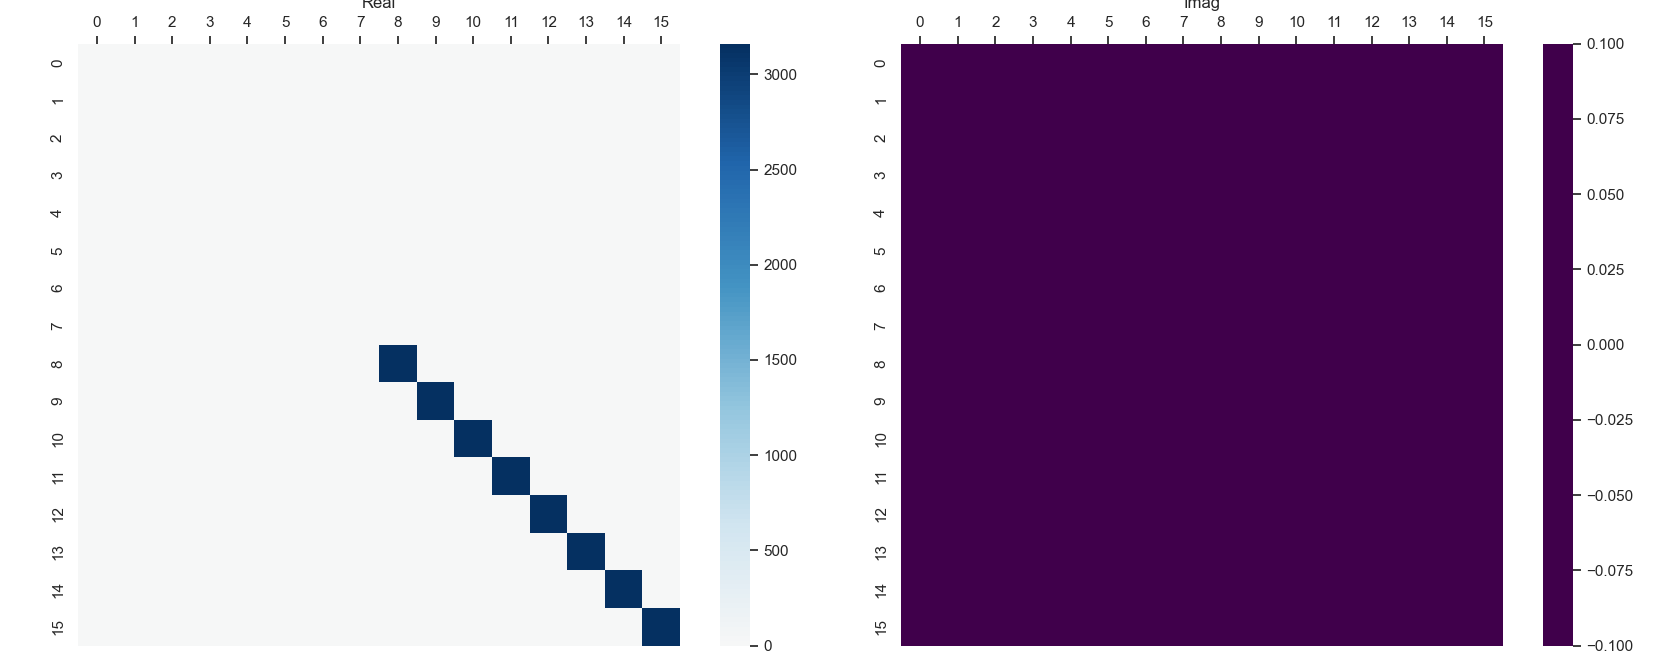

In [40]:
matrixplot(sum(dephasing_excited_states(line="D1")))

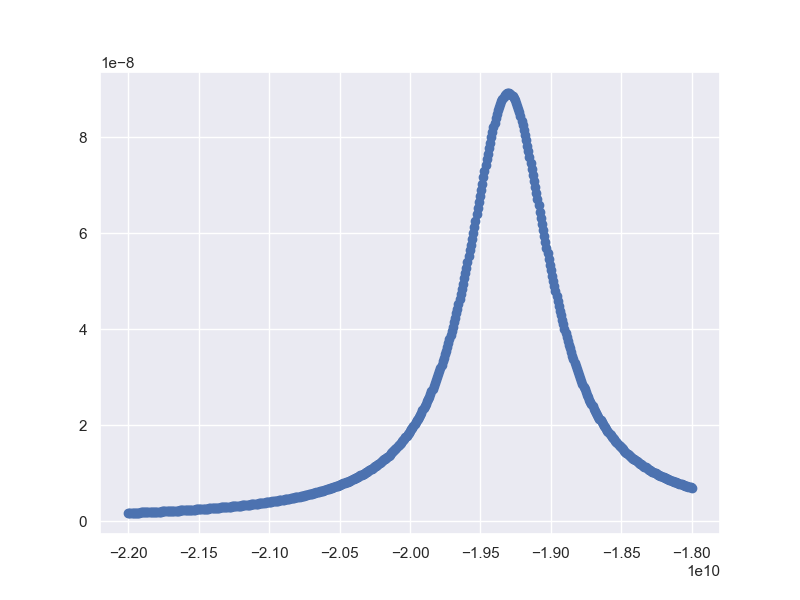

In [41]:
freqs = np.linspace(-2.2e10, -1.8e10, 501)
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.figure()
plt.plot(freqs, excited_pops, "o")

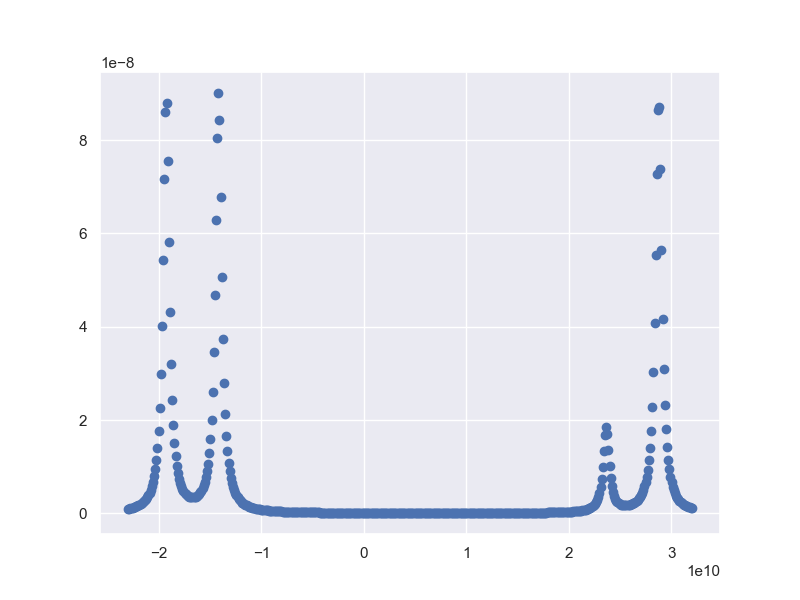

In [42]:
freqs = np.linspace(-2.3e10, 3.2e10, 501)
rho_ss_list = [steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(det, "D1"), c_op_list=decays) for det in freqs]
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.figure()
plt.plot(freqs, excited_pops, "o")

In [43]:
od = np.exp(-np.array(excited_pops))

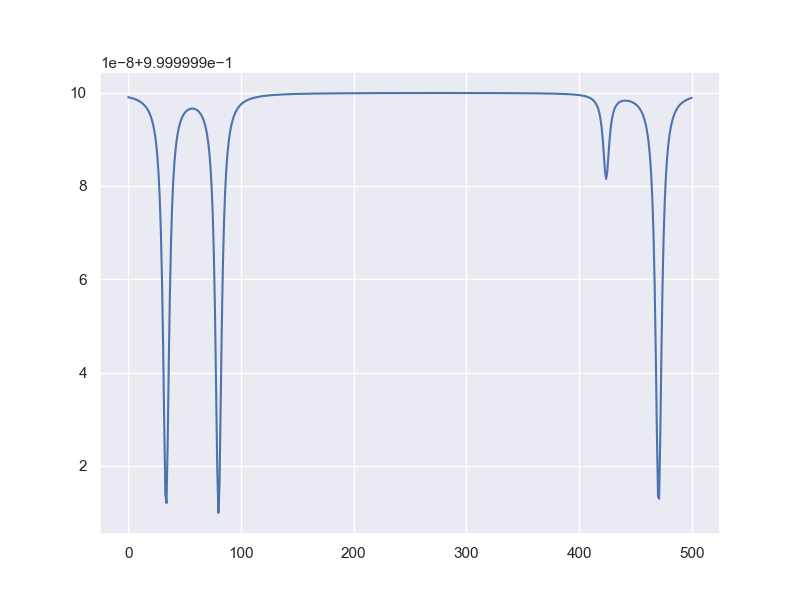

In [44]:
plt.figure()
plt.plot(od)

In [45]:
od = np.exp(-1e6*np.array(excited_pops))

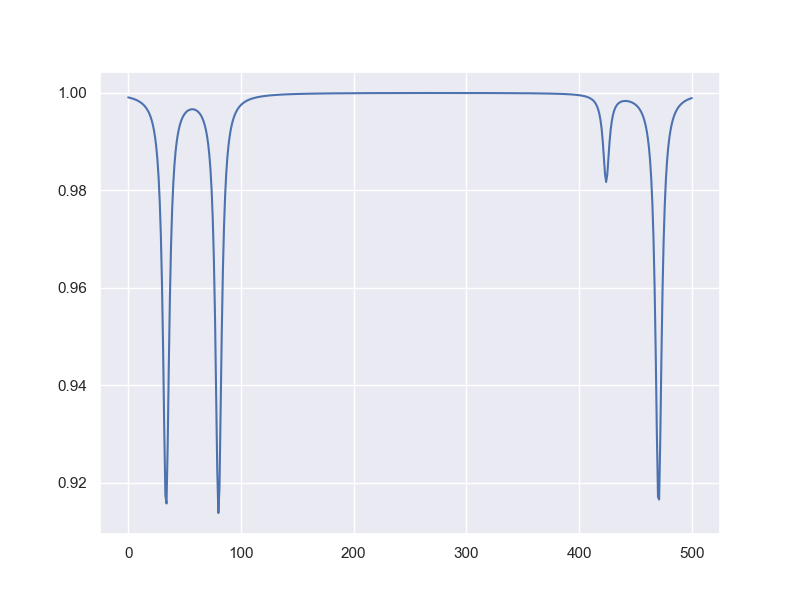

In [46]:
plt.figure()
plt.plot(od)

In [47]:
pd

NameError: name 'pd' is not defined

In [48]:
import pandas as pd

In [49]:
pd.DataFrame(od, index=freqs/(2*pi))

,0
-3.660564e+09,0.999026
-3.643057e+09,0.998971
-3.625550e+09,0.998912
-3.608043e+09,0.998847
-3.590536e+09,0.998776
...,...
5.022930e+09,0.998530
5.040437e+09,0.998635
5.057944e+09,0.998729
5.075451e+09,0.998814


In [50]:
df_sim = pd.DataFrame(od, index=freqs/(2*pi))

In [51]:
df_sim.to_csv("sim.csv")

In [52]:
df_sim = pd.DataFrame(od, index=freqs/(2e9*pi))

In [53]:
df_sim.to_csv("sim.csv")